In [6]:
import dask.dataframe as dd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from data_preprocessing_pao import *

# File download

In [3]:
X_file = "data/X_matrix.csv"
Y_file = "data/y_phenotype.csv"

print("Loading the data...")
X = pd.read_csv(X_file)
Y = pd.read_csv(Y_file)

Loading the data...


In [4]:
# Ensure Yeast_ID is a string type
X['Yeast_ID'] = X['Yeast_ID'].astype(str)
Y['Yeast_ID'] = Y['Yeast_ID'].astype(str)

# Filter to keep only the common Yeast_IDs
print("All Yeast_ID of X are in y: ", X['Yeast_ID'].isin(Y['Yeast_ID']).all())
print("All Yeast_ID of y are in X: ", Y['Yeast_ID'].isin(X['Yeast_ID']).all())

# Check if Yeast_ID columns are in the same order
if all(X["Yeast_ID"] == Y["Yeast_ID"]):
    print("Yeast_IDs are aligned and in the same order.")
else:
    print("Error: Yeast_IDs are not aligned after filtering.")

print("X contains NaN values: ", X.isna().any().any())
print("y contains NaN values: ", Y.isna().any().any())

# Display the dimensions of the filtered matrices
print(f"Dimensions de X : {X.shape}")
print(f"Dimensions de Y : {Y.shape}")

All Yeast_ID of X are in y:  True
All Yeast_ID of y are in X:  True
Yeast_IDs are aligned and in the same order.
X contains NaN values:  False
y contains NaN values:  False
Dimensions de X : (792, 347953)
Dimensions de Y : (792, 2)


In [6]:
# Préparation des données
print("Préparation des données...")
X_data = X.drop(columns=["Yeast_ID"])  # Remplacer les valeurs manquantes par 0 dans X
y_data = Y.drop(columns=["Yeast_ID"])
print(f"Dimensions de X : {X_data.shape}")
print(f"Dimensions de Y : {y_data.shape}")

Préparation des données...
Dimensions de X : (792, 347952)
Dimensions de Y : (792, 1)


# File download 2 -> Begin directly here to win time

In [ ]:
X = "data/X_matrix.csv"
Y = "data/y_phenotype.csv"

print("Loading the data...")

# Load the column names (header)
column_names = np.genfromtxt(X, delimiter=',', max_rows=1, dtype=str)[1:]  # Skip the first column if it's row names

# Load the row names (index) from the first column and the data (excluding first column)
data = np.loadtxt(X, delimiter=',', skiprows=1, usecols=range(1, 348523))
row_names = np.loadtxt(X, delimiter=',', skiprows=1, usecols=0, dtype=str)

# Create the DataFrame
X_file = pd.DataFrame(data, index=row_names, columns=column_names)
X_file = pd.DataFrame(data, columns=column_names)
y_file = pd.read_csv(Y)

X_data = X_file.drop(columns=["Yeast_ID"])  # Remplacer les valeurs manquantes par 0 dans X
y_data = y_file.drop(columns=["Yeast_ID"])
print(f"Dimensions de X : {X_data.shape}")
print(f"Dimensions de Y : {y_data.shape}")

In [49]:
X_data_f, y_data_f = preprocessed_data(X_data, y_data)

In [50]:
metrics(X_data,X_data_f)

Dimensions of the DataFrame (original): (792, 347952)
Dimensions of the DataFrame (after preprocessing): (792, 341990)

Mean of all values (original): 0.031414799995161016
Mean of all values (after preprocessing): 0.025658214514454155

Max value (original): 1.0 Min value (original): 0.0
Max value (after preprocessing): 1.0 Min value (after preprocessing): 0.0

Standard deviation (original): 0.16387554719923494
Standard deviation (after preprocessing): 0.15803376183534157

Variance (original): 0.02685519496984868
Variance (after preprocessing): 0.02497466987982946


In [51]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensemble d'entraînement et de test...")
X_train, X_test, y_train, y_test = train_test_split(X_data_f, y_data_f, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles pour validation
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Division des données en ensemble d'entraînement et de test...
Dimensions de X_train: (633, 341990)
Dimensions de X_test: (159, 341990)
Dimensions de y_train: (633,)
Dimensions de y_test: (159,)


# Random Forest

In [52]:
# Entraîner un modèle Random Forest
print("Entraînement du modèle Random Forest...")
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

Entraînement du modèle Random Forest...


RandomForestRegressor(random_state=42)

In [53]:
# Prédictions
print("Évaluation du modèle...")
y_pred = model.predict(X_test)

Évaluation du modèle...


# XGBoost

In [55]:
# Définir un modèle XGBoost
print("Définition du modèle XGBoost...")
xgb_model = XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    max_depth=6,       # Profondeur maximale des arbres
    learning_rate=0.1, # Taux d'apprentissage
    subsample=0.8,     # Sous-échantillonnage des données
    colsample_bytree=0.8,  # Sous-échantillonnage des features
    random_state=42
)

#Validation croisée sur xgb
print("Lancement de la validation croisée...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Validation croisée en 5-fold
cv_scores = cross_val_score(xgb_model, X_data_f, y_data_f, cv=kf, scoring="r2")

print(f"Scores de validation croisée (R²): {cv_scores}")

Définition du modèle XGBoost...
Lancement de la validation croisée...
Scores de validation croisée (R²): [-0.01860866 -0.00875458  0.05244922 -0.30572404 -0.14285072]


In [ ]:
# Entraîner le modèle sur l'ensemble des données d'entraînement
print("Entraînement du modèle sur l'ensemble des données...")
xgb_model.fit(X_data_f, y_data_f)

Entraînement du modèle sur l'ensemble des données...
Division des données pour évaluation...
Prédictions sur les données de test...


# Predictions

In [56]:
# Entraînement final sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
print("Prédictions sur les données de test...")
y_pred = xgb_model.predict(X_test)

Prédictions sur les données de test...


In [57]:
# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Importance des caractéristiques
print("Calcul de l'importance des caractéristiques...")
feature_importances = pd.DataFrame({
    "Feature": X_data_f.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Afficher les mutations les plus importantes
top_mutations = feature_importances.head(10)
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

Mean Squared Error: 0.08791647673952753
R² Score: -0.05392471462396653
Calcul de l'importance des caractéristiques...

Mutations ayant le plus d'impact sur le YPD doubling time :
                  Feature  Importance
226553  YLR320W_1167_E->G    0.019304
198668   YKL218C_169_G->R    0.011532
199364   YKR003W_411_A->V    0.010144
313428   YOR346W_825_V->I    0.009639
41281    YDL039C_246_V->A    0.009031
1812      YAL028W_67_A->T    0.008638
32090     YCL052C_29_T->I    0.008602
45896    YDL127W_180_K->I    0.008396
138038  YHL030W_1282_L->W    0.007985
247803  YMR105W-A_60_I->F    0.006896


Affichage des résultats...


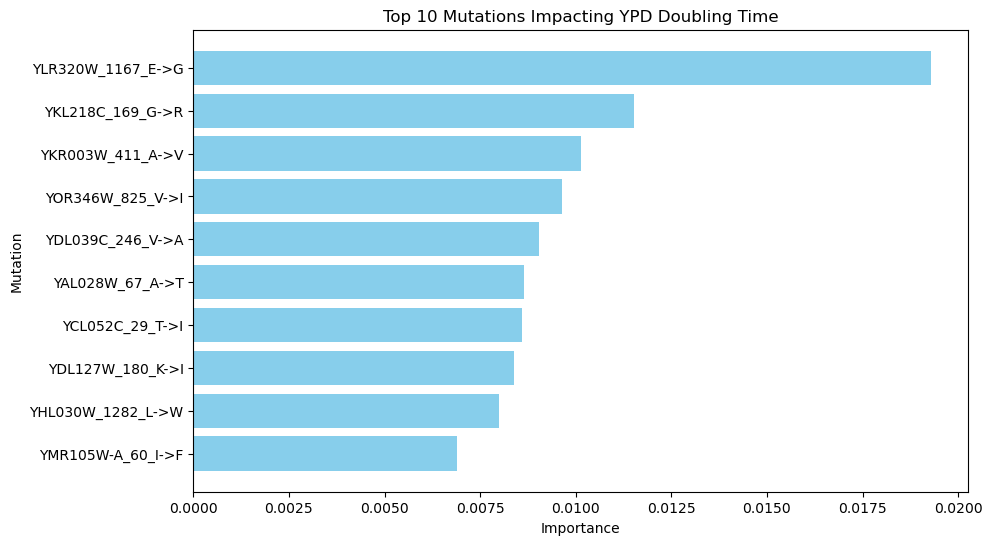

In [58]:
# Visualisation des résultats
print("Affichage des résultats...")
plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()